In [75]:
# Import Dataset
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from keras.applications.xception import preprocess_input
from sklearn.metrics import confusion_matrix
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [76]:
# Location Path
train_path  = 'drive/My Drive/data pekalongan/2 kelas/train'
valid_path  = 'drive/My Drive/data pekalongan/2 kelas/valid'
test_path  = 'drive/My Drive/data pekalongan/2 kelas/test'

In [77]:
# Data Augmentation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./127.5-1.,
)

# Train, Test, Validation
train_batches = datagen.flow_from_directory(
    train_path, target_size=(299,299), batch_size=10)
valid_batches = datagen.flow_from_directory(
    valid_path, target_size=(299,299), batch_size=15)
test_batches = datagen.flow_from_directory(
    test_path, target_size=(299,299), batch_size=40)

Found 3360 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [78]:
from collections import Counter

samples = Counter(train_batches.classes)

print(samples.items()) # dict_items([(0, 1648), (1, 3614)])

training_examples = 0;
for item in samples.items():
    training_examples += item[1]

print(training_examples)

dict_items([(0, 1680), (1, 1680)])
3360


In [79]:
def entry_flow(inputs):

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x  # Set aside residual
  
  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for size in [128, 256, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = layers.Conv2D(  # Project residual
        size, 1, strides=2, padding='same')(previous_block_activation)           
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  return x


def middle_flow(x, num_blocks=8):
  
  previous_block_activation = x

  for _ in range(num_blocks):
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, previous_block_activation])  # Add back residual
    previous_block_activation = x  # Set aside next residual
    
  return x


def exit_flow(x, num_classes=1000):
  
  previous_block_activation = x

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(728, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  
  x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

  residual = layers.Conv2D(  # Project residual
      1024, 1, strides=2, padding='same')(previous_block_activation)
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.SeparableConv2D(1536, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  
  x = layers.SeparableConv2D(2048, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.4)(x)
  if num_classes == 1:
    activation = 'sigmoid'
  else:
    activation = 'softmax'
  return layers.Dense(num_classes, activation=activation)(x)

In [80]:
keras.backend.clear_session()

# Create Xception by chaining the 3 flows
inputs = keras.Input(shape=(299, 299, 3))
outputs = exit_flow(middle_flow(entry_flow(inputs), num_blocks=8), num_classes=2)
xception = keras.Model(inputs, outputs)

In [81]:
# Custom Early Stopping
# Expected behavior: EarlyStopping should restore weights on end of training regardless it stop training early or after the last epoch

class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_val_loss = np.Inf
        self.best_loss = np.Inf
        self.best_val_accuracy = 0.0
        self.best_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None): 
        val_loss = logs.get('val_loss')
        loss = logs.get('loss')
        val_accuracy = logs.get('val_accuracy')
        accuracy = logs.get('accuracy')

        # if np.less(val_loss, self.best_val_loss) and np.greater(map10, self.best_map10):
        if np.greater_equal(val_accuracy, self.best_val_accuracy) and np.greater_equal(accuracy, self.best_accuracy) and np.greater_equal(accuracy, val_accuracy):
            self.best_val_loss = val_loss
            self.best_loss = loss
            self.best_val_accuracy = val_accuracy
            self.best_accuracy = accuracy
            self.wait = 0

            # Record the best weights if current results is better.
            print("Saving the best weight at epoch {}".format(epoch + 1))
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Training stop early. Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
                
    def on_train_end(self, logs=None):
        # EarlyStopping will restore weights after the last epoch only if it is not stop early
        if self.stopped_epoch > 0:
            print("Epoch {}: early stopping".format(self.stopped_epoch + 1))
        else:
            print("Training stop after the last epoch. Restoring model weights from the end of the best epoch.")
            self.model.set_weights(self.best_weights)

In [82]:
xception.compile(RMSprop(learning_rate=3e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [83]:
# Callback to save the current best model
epochs = 1000
patience = epochs

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=80, mode='min', verbose=1, restore_best_weights=True),
    #CustomEarlyStopping(patience=patience),
    #tf.keras.callbacks.ModelCheckpoint(filepath='batik-recognition-model.{epoch:03d}.hdf5',  monitor='val_accuracy', mode='max', verbose=0, save_best_only=False),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

# Using Batch Gradient Descent (batch_size = training_examples) because data is less than 2000
# Stochastic Gradient Descent (batch_size = 1)
# Mini-Batch Gradient Descent (batch_size = 1 < number_power_of_2 < training_examples)
# steps per epoch = 18
# validation steps = 3
history = xception.fit(train_batches, 
                        steps_per_epoch=4, 
                        batch_size=training_examples, 
                        validation_data=valid_batches, 
                        validation_steps=2, 
                        epochs=epochs, verbose=2, 
                        callbacks=my_callbacks,
                        shuffle=True)

Epoch 1/1000
4/4 - 12s - loss: 0.8262 - accuracy: 0.6500 - val_loss: 0.6946 - val_accuracy: 0.4000 - 12s/epoch - 3s/step
Epoch 2/1000
4/4 - 2s - loss: 0.9742 - accuracy: 0.5000 - val_loss: 0.6908 - val_accuracy: 0.6667 - 2s/epoch - 573ms/step
Epoch 3/1000
4/4 - 2s - loss: 0.7539 - accuracy: 0.5500 - val_loss: 0.6915 - val_accuracy: 0.6333 - 2s/epoch - 526ms/step
Epoch 4/1000
4/4 - 2s - loss: 0.5032 - accuracy: 0.8000 - val_loss: 0.6931 - val_accuracy: 0.5000 - 2s/epoch - 531ms/step
Epoch 5/1000
4/4 - 2s - loss: 0.6188 - accuracy: 0.7000 - val_loss: 0.6932 - val_accuracy: 0.3333 - 2s/epoch - 538ms/step
Epoch 6/1000
4/4 - 2s - loss: 0.6348 - accuracy: 0.7500 - val_loss: 0.6931 - val_accuracy: 0.5333 - 2s/epoch - 556ms/step
Epoch 7/1000
4/4 - 2s - loss: 0.6727 - accuracy: 0.6500 - val_loss: 0.6931 - val_accuracy: 0.5000 - 2s/epoch - 542ms/step
Epoch 8/1000
4/4 - 2s - loss: 0.6923 - accuracy: 0.6250 - val_loss: 0.6929 - val_accuracy: 0.5667 - 2s/epoch - 546ms/step
Epoch 9/1000
4/4 - 2s - l

In [84]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [85]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset(test_path)

In [86]:
from keras.preprocessing import image  
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 320/320 [00:01<00:00, 200.19it/s]


In [87]:
# Model Testing
# if you want to select the model yourself, uncomment the next line and change the filename as the one you choose
# new_model.load_weights('filename.hdf5')

print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*xception.evaluate(test_tensors, test_targets)))

10/10 [==============================] - 4s 318ms/step - loss: 1.1289 - accuracy: 0.5656

Testing loss: 1.1289
Testing accuracy: 0.5656


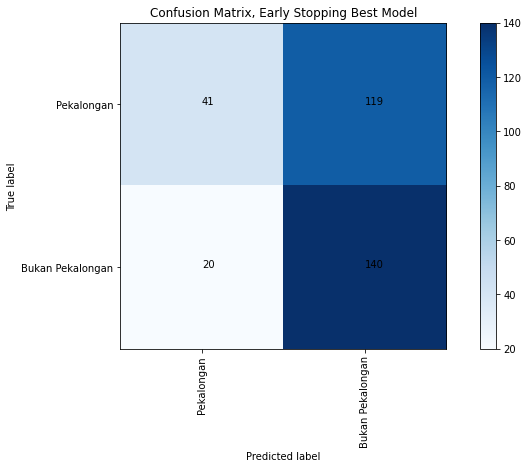

In [88]:
# Confussion Matrix
from sklearn.metrics import confusion_matrix

cm_labels = ['Pekalongan', 'Bukan Pekalongan']

y_true = np.argmax(test_targets, axis=1)
y_pred = np.argmax(xception.predict(test_tensors), axis=1)

plt.figure(figsize=(12, 6))
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion Matrix, Early Stopping Best Model')
plt.show()

In [89]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(np.argmax(test_targets, axis=1), np.argmax(xception.predict(test_tensors), axis=1), target_names=cm_labels))

                  precision    recall  f1-score   support

      Pekalongan       0.67      0.26      0.37       160
Bukan Pekalongan       0.54      0.88      0.67       160

        accuracy                           0.57       320
       macro avg       0.61      0.57      0.52       320
    weighted avg       0.61      0.57      0.52       320



In [90]:
# Geometric Mean
from imblearn.metrics import geometric_mean_score
geometric_mean_score(y_true, y_pred, pos_label=1, average=None, correction=0.0)

array([0.47351742, 0.47351742])